# Disaster aware routing with openrouteservice

In times of disaster, such as the devastating flood event that occurred in the Ahr valley in Germany in July 2021, **routing becomes crucial for emergency responders, humanitarian organizations, and disaster management teams** to distribute help quickly and efficiently. Openrouteservice, an open-source routing engine built on OpenStreetMap data, offers a **powerful** and **flexible** solution for **navigation** and **logistics** **planning** in such scenarios.

This training aims to **familiarize participants with the capabilities of openrouteservice within Python** and demonstrate how it can be leveraged to address routing challenges during a disaster. Through a series of code examples we will explore the key features and functionalities of openrouteservice. You will learn how easy it is to interact with openrouteservice from Python and be able to integrate it directly into your own workflow.

# Context

During the Ahr valley flood event, many roads and bridges were damaged or rendered impassable, posing significant challenges for navigation and transportation. In such situations, openrouteservice can assist in finding alternative routes which avoid damaged roads to deliver essential supplies and services to affected areas.

# Setup

Load all necessary modules.

In [1]:
from openrouteservice import client
from openrouteservice.exceptions import ApiError
import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from branca.colormap import linear
from shapely.geometry import Point, mapping

### Set up openrouteservice

Make sure that you have a [personal key for the public openrouteservice API](https://openrouteservice.org/dev/#/login). Insert **your API key** below.

In [2]:
api_key = '5b3ce3597851110001cf6248eef794d1244544f7826f417356aee9e4'

**Create a ORS client** which will be used to send request to the API. 

In [3]:
ors_client = client.Client(key=api_key)

# Simple routing and avoid areas

Let's start to use the openrouteservice library by performing a **simple A-to-B routing task**. We start by defining an origin and destination and then call the API to create a route out of it. The coordinates provided in the code chunk point to the ***Nürburgring*, a motorsports complex in rural Rhineland-Palatinate, which served as staging area during the emergency response.** In this area, rescue helpers from all over Germany were stationed to sleep, eat and repair their equipment inbetween deployments. The destination coordinates point to ***Bad Neuenahr-Ahrweiler***, the largest community affected by the flood in Rhineland-Palatinate.

## Create a route from Nürburgring to Bad Neuanahr-Ahrweiler

Defines the coordinates of the staging area, Nürburgring

In [9]:
staging_area_coordinates = (6.943241, 50.334265)
staging_area_df = gpd.GeoDataFrame({'geometry': [Point(staging_area_coordinates)], 'name': ['Bad Neuenahr']}, crs="epsg:4326")

Defines the coordinates of Bad Neuenahr-Ahrweiler

In [10]:
badneuenahr_coordinates = [7.119166, 50.548979]
badneuenahr_df = gpd.GeoDataFrame({'geometry': [Point(badneuenahr_coordinates)], 'name': ['Bad Neuenahr']}, crs="epsg:4326")

Let's define the request parameters 

In [23]:
request_params = {'coordinates': [staging_area_coordinates, badneuenahr_coordinates],
                 'format_out': 'geojson',
                 'profile': 'driving-car',
                 'preference': 'recommended',
                 'instructions': False}

Send request to ORS

In [13]:
route_directions = ors_client.directions(**request_params)

Convert ORS response to GeoDataFrame

In [14]:
route = gpd.GeoDataFrame.from_features(route_directions).set_crs(epsg=4326)

Print it on an interactive map using `GeoPandas` great `explore()` method! 

In [15]:
m = route.explore(tiles='cartodbpositron')
staging_area_df.explore(m=m, color='red', marker_kwds={'radius': 15})
badneuenahr_df.explore(m=m, color='blue', marker_kwds={'radius': 15})

The `ors_directions` function consumes a list of numeric vectors which contain the coordinates of origin and destination. You can also add up to 50 waypoints in between. Via the output parameter you can control the structure of the response. The parameters explained:

-   profile: The default is `driving-car`, however `pedestrian`, different `cycle`, `heavy vehicles`, `wheelchair` are possible as well

-   preference: The default is `fastest`. `shortest` and `recommended` are other possible values.

-   options: Not set by default. It represents an additional object with further parameters to individualize the request like:

    -   avoid_borders: Do not route through controlled borders, or none at all

    -   avoid_countries: Do not route through specified countries.

    -   avoid_features: Do not route via ferries or tolways

    -   **avoid_polygons:** Do not route through a customized area. Must be formatted in GeoJSON as either a Polygon or Multipolygon object. Featurecollections are not supported

Check out all available parameters with the interactive API playground here:

[openrouteservice.org/dev/#/api-docs/v2/directions/{profile}/post](https://openrouteservice.org/dev/#/api-docs/v2/directions/%7Bprofile%7D/post)

For the purpose of disaster aware routing we will now use the lastly mentioned parameter and define an area to be avoided by the route calculation.


## Disaster aware route from Nürburgring to Bad Neuanahr-Ahrweiler

Now let's calculate the same route after the flood has destroyed roads and bridges. 

### Calculate routes from base camp to the affected places 

Building upon the concepts and skills acquired, we tackle a more complex task. We utilize data from the Copernicus Emergency Mapping service, which provides information on destroyed or damaged roads and bridges in the Ahr valley, to calculate routes from the disaster relief staging area at the Nürburgring. Our objective is to reach 36 locations representing the affected communities in the valley.
For this purpose we need the following additional data:

-   `affected_roads_bridges` All damaged and destroyed roads and bridges provided by the Copernicus Emergency Mapping Service. This dataset as well as others are available here: <https://emergency.copernicus.eu/mapping/list-of-components/EMSR517>

-   `affected_places` All place=\* objects from OpenStreetMap that are located within the boundaries of municipalities that where affected.

You find the files also in the repo this R-Markdown file is located in. <https://github.com/GIScience/openrouteservice-workshop-r/tree/master/data>

First, we need to add the affected roads and bridges to the quer parameters as areas to avoid.

In [16]:
affected_roads_bridges = gpd.read_file("../resources/data/ahrtal/affected_roads.gpkg")
affected_roads_bridges['id'] = affected_roads_bridges.index
affected_places = gpd.read_file("../resources/data/ahrtal/affected_places.gpkg")

As before we need to prepare the avoid areas for the openrouteservice query. The roads and bridges are of type `LINESTRING.` The APIs avoid area parameter however can only consume single polygons or multipolygons. Therefore we need convert it via buffer and union into one continuous multipolygon.

In [17]:
affected_roads_bridges_union = affected_roads_bridges.copy()
affected_roads_bridges_union.geometry = affected_roads_bridges_union.geometry.to_crs('25832').buffer(2).to_crs('4326').make_valid()
affected_roads_bridges_union = affected_roads_bridges_union.dissolve()
affected_roads_bridges_union.geometry = affected_roads_bridges_union.make_valid()

Let's look at the data on a map. Affected places are shown in blue, damaged roads and bridges in red. 

In [18]:
m = affected_roads_bridges.explore(color='red', tooltip=['id'], tiles='cartodbpositron', legend=True)
affected_places.explore(m=m, color='blue', legend=True)
staging_area_df.explore(m=m, color='green')


Next we loop over all communities in `affected_places`. Some communities won't be reachable at all, they were cut off by the disaster. Openrouteservice will throw errors for these destinations, as it won't be able to create a route. We account for this circumstance with a `try except` block.

#### Define request parameters
The request parameters will be the same as before. But for the route request after flood, the roads to be avoided need to be addedn to the query.

In [24]:
request_params_flood = request_params.copy()
request_params_flood['options'] = {'avoid_polygons': mapping(affected_roads_bridges_union.make_valid().geometry[0])}

Now one request will be sent for each affected place. 

**Note:** You might get warnings like `UserWarning: Rate limit exceeded. Retrying for the 3rd time.`. This means you have exceeded your minutly quote, just let the script run, it will retry sending the requests until they are successful. 

In [25]:
normal_routes = []
avoiding_routes = []

for i, p in affected_places.iterrows():

    # Calculate route before the flood
    request_params['coordinates'] = [staging_area_coordinates, (p.geometry.x, p.geometry.y)]
    directions_normal = ors_client.directions(**request_params)
    directions_normal_df = gpd.GeoDataFrame().from_features(directions_normal)
    directions_normal_df['name'] = p['name']
    directions_normal_df['id'] = i

    # Calculate route after the flood
    try:
        request_params_flood['coordinates'] = [staging_area_coordinates, (p.geometry.x, p.geometry.y)]
        directions_flood = ors_client.directions(**request_params_flood)
        directions_flood_df = gpd.GeoDataFrame().from_features(directions_flood)
        directions_flood_df['name'] = p['name']
        directions_flood_df['id'] = i
    except ApiError as e:
        #print(e)
        print(f"No route found for {p['name']}")
        continue
    
    avoiding_routes.append(directions_flood_df)    
    normal_routes.append(directions_normal_df)


/Users/cludwig/opt/miniconda3/lib/python3.9/site-packages/openrouteservice/client.py:211: UserWarning: Rate limit exceeded. Retrying for the 1st time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
/Users/cludwig/opt/miniconda3/lib/python3.9/site-packages/openrouteservice/client.py:211: UserWarning: Rate limit exceeded. Retrying for the 2nd time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
/Users/cludwig/opt/miniconda3/lib/python3.9/site-packages/openrouteservice/client.py:211: UserWarning: Rate limit exceeded. Retrying for the 3rd time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
/Users/cludwig/opt/miniconda3/lib/python3.9/site-packages/openrouteservice/client.py:211: UserWarning: Rate limit exceeded. Retrying for the 4th time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
/Users/cludwig/o

No route found for Brück 2
No route found for Altenburg
No route found for Pützfeld
No route found for Rech
No route found for Schuld 4


We see, the communities of Altenburg, Brück 2, Schuld4, Pützfeld and Rech are unfortunately were no longer reachable via regular motorized transport. These communities were the first to be set up with temporary bridges.

For the communities, however where could generate disaster aware routes, we are now able to determine access paths. Further we can determine the increase in travel time to the communities. For this purpose we need to do some postprocessing of our results. The chunk below will unpack served attributes by openrouteservice on time and distance information for every route. Then a time difference is calculated as new column.

In [26]:
normal_routes_df = gpd.GeoDataFrame(pd.concat(normal_routes)).set_crs(epsg=4326).set_index('id')
avoiding_routes_df = gpd.GeoDataFrame(pd.concat(avoiding_routes)).set_crs(epsg=4326).set_index('id')

normal_routes_df['duration'] = normal_routes_df.summary.map(lambda x: x['duration'])
avoiding_routes_df['duration'] = avoiding_routes_df.summary.map(lambda x: x['duration'])

avoiding_routes_df = avoiding_routes_df.join(normal_routes_df[['duration']], lsuffix='_avoid')
avoiding_routes_df['duration_difference'] = (avoiding_routes_df.duration_avoid - avoiding_routes_df.duration) / 60. 
avoiding_routes_df['duration_difference_percent'] = (avoiding_routes_df.duration_avoid - avoiding_routes_df.duration) / avoiding_routes_df.duration_avoid * 100.
affected_places_dur = affected_places.join(avoiding_routes_df[['duration_difference', 'duration_difference_percent']])

# Analysis & Evaluation

In this code chunk, we will take the first step towards analyzing and evaluating the travel time differences between regular routes and routes that bypass flood-affected infrastructure. We will create classes that allow us to extract more meaning and insights from these differences. For this purpose we use the `classInt` package.

In the following code chunk, we will create a bar plot for each affected community, showcasing the travel time differences between regular routes and disaster-aware routes. Before plotting, we will sort the data based on a leveled factor x variable to ensure a visually appealing and informative representation.

Text(0.5, 0, 'Affected places')

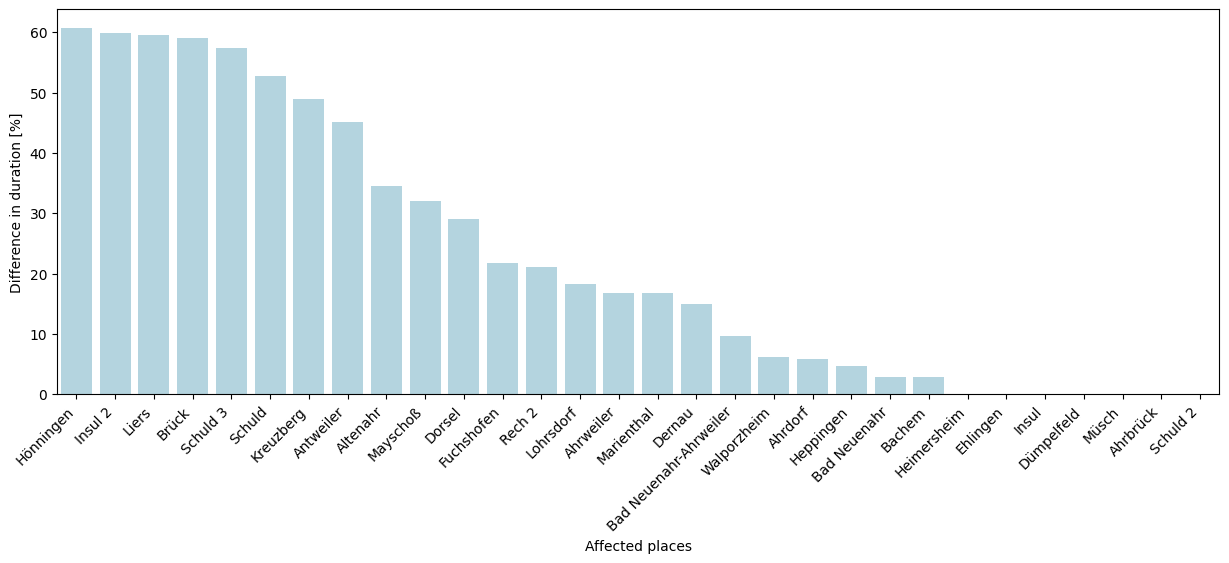

In [32]:
fig, axes = plt.subplots(1,1, figsize=(15, 5))
sns.barplot(data=avoiding_routes_df.sort_values('duration_difference_percent', ascending=False), 
            x='name', y='duration_difference_percent', color='lightblue',
           ax=axes)
plt.xticks(rotation = 45, ha='right')
plt.ylabel('Difference in duration [%]')
plt.xlabel('Affected places')

In [43]:
print(f"Mean travel time difference: {avoiding_routes_df['duration_difference'].mean()}")
print(f"Median travel time difference: {avoiding_routes_df['duration_difference'].median()}")

Mean travel time difference: 13.639444444444445
Median travel time difference: 8.644166666666667


The bar plot will visually represent these travel time differences, allowing for easy comparison among the affected communities. By sorting the data based on the leveled factor in the x variable, the plot will display the communities in descending traveltime increase.

-   There are 7 communities where there is no travel time difference between the regular and disaster-aware routes

-   8 communities show increaes in travel duration larger than 40%. 

-   Overall the mean traveltime difference is at 13.64 min and the median at 8.64 min. Not including the 5 not reachable communities.


### Showing the results on the map

One last thing before we are done is plotting the results on a map. In addition, you can select one of the communities by name to show the route berfore and after the flood. Just adjust the `place_name = 'Insul 2'` variable. Try out different place names. What do you observe?

In [77]:
place_name = 'Insul 2'
m = affected_places_dur.explore(column='duration_difference_percent', 
                            tooltip=['name', 'duration_difference_percent','duration_difference'],
                            popup=True,  # show all values in popup (on click)
                            tiles="CartoDB positron",  # use "CartoDB positron" tiles
                            cmap='Reds', vmin=0, vmax=affected_places_dur['duration_difference_percent'].max(),
                            marker_kwds=dict(radius=10, fill=True))
staging_area_df.explore(
    m=m,
    marker_type='marker',
    marker_kwds={'icon': folium.map.Icon(icon='people')},
    color="orange", 
)
avoiding_routes_df.loc[avoiding_routes_df['name'] == place_name].explore(
    m=m,
    highlight=True,
    name='Route after flood',
    legend=True,
    tooltip=['name', 'duration'],
    popup=True,
    color="red")
normal_routes_df.loc[normal_routes_df['name'] == place_name].explore(
    m=m,
    name='Route before flood',
    tooltip=['name', 'duration'],
    popup=True,
    color="green")
affected_roads_bridges.explore(m=m, color='red',tooltip=['id'])
m

normal_routes_df.loc[normal_routes_df['name'] == place_name].explore(
    m=m,
    name='Route before flood',
    tooltip=['name', 'duration'],
    popup=True,
    categorical=True,
    color="green")